In [0]:
%matplotlib inline

In [0]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('../data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 380911 sentence pairs
Trimmed to 22942 sentence pairs
Counting words...
Counted words:
rus 9108
eng 3945
['она пробыла там недолго .', 'she stayed there for a short while .']


The Encoder
-----------





In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Original Decoder with global attention
-----------




In [0]:
class AttnDecoderRNN(nn.Module):
    def _print(self, text):
        if self.debug:
            print(text)

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, debug=False):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.debug = debug

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        self._print(f'embedded[0].shape : {embedded[0].shape}')
        self._print(f'hidden[0].shape : {hidden[0].shape}')
    
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        self._print(f'attn_weights.shape before gru {attn_weights.shape}')
        self._print(f'attn_weights.unsqueeze(0) {attn_weights.unsqueeze(0).shape}')
        self._print(f'encoder_outputs.unsqueeze(0) {encoder_outputs.unsqueeze(0).shape}')
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        self._print(f'attn_applied.shape before gru {attn_applied.shape}')
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        self._print(f'output.shape after torch.cat((embedded[0], attn_applied[0]), 1) {output.shape}')
        output = self.attn_combine(output).unsqueeze(0)
        self._print(f'output.shape after self.attn_combine(output).unsqueeze(0) {output.shape}')

        output = F.relu(output)
        self._print(f'hidden.shape before gru {hidden.shape}')
        self._print(f'output.shape after F.relu(output) and before gru {output.shape}')
        output, hidden = self.gru(output, hidden)
        self._print(f'output.shape after self.gru(output, hidden) {output.shape}')
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        self._print(f'output.shape after softmax: {output.shape}, hidden.shape {hidden.shape}' +
              f'attn_weights.shape : {attn_weights.shape}')
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# for debug
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=100)

## The Decoder with attention based on scaled dot-product 

In [0]:
class ScalarAttnDecoderRNN(nn.Module):
    def _print(self, text):
        if self.debug:
            print(text)

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, debug=False):
        super(ScalarAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.debug = debug

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        self._print(f'embedded.shape before bmm {embedded.shape}')
        self._print(f'hidden.shape before bmm {hidden.shape}')
        self._print(f'encoder_outputs.unsqueeze(0).shape before bmm {encoder_outputs.unsqueeze(0).shape}')
        attn_weights = F.softmax(
            torch.bmm(hidden, encoder_outputs.squeeze(0).T.unsqueeze(0)).squeeze(0), dim=1)
        self._print(f'attn_weights.shape before bmm {attn_weights.shape}')    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        self._print(f'attn_applied.shape after bmm {attn_applied.shape}')
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        self._print(f'final output.shape {output.shape}')
        if self.debug:
            return
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# only for debug
hidden_size = 256
encoder_scalar = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_scalar = ScalarAttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder_scalar, attn_decoder_scalar, 10000, print_every=100)

## The Decoder with attention based on MLP

In [0]:
class MLPAttnDecoderRNN(nn.Module):
    def _print(self, text):
        if self.debug:
            print(text)

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, debug=False):
        super(MLPAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.debug = debug

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.Wk = nn.Linear(hidden_size, hidden_size)#, bias=False)
        self.Wq = nn.Linear(hidden_size, hidden_size)#, bias=False)

        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        self._print(f'embedded shape : {embedded.shape}') #hidden size :  torch.Size([1, 1, 256])
        self._print(f'hidden size : {hidden.shape}') #hidden size :  torch.Size([1, 1, 256])
        self._print(f'encoder_outputs.shape : {encoder_outputs.shape}') #encoder_outputs.shape :  torch.Size([10, 256])
        wk = self.Wk(hidden.squeeze(0))
        self._print(f'wk.shape : {wk.shape}')
        wq = self.Wq(encoder_outputs)
        self._print(f'wq.shape : {wq.shape}')
        
        attn_weights = torch.tanh( wk + wq )
        attn_weights = torch.bmm(embedded, attn_weights.T.unsqueeze(0))
        attn_weights = F.softmax(attn_weights.squeeze(0), dim=1)
        self._print(f'attn_weights.squeeze(0) shape : {attn_weights.squeeze(0).shape}')
        self._print(f'encoder_outputs.unsqueeze(0) shape : {encoder_outputs.unsqueeze(0).shape}')

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output, hidden = self.gru(output, hidden)
        self._print(f'output.shape after gru : {output.shape}, output[0].shape : {output[0].shape}')
    
        output = F.log_softmax(self.out(output[0]), dim=1)
        self._print(f'output.shape after softmax : {output.shape}')
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# only for debug
hidden_size = 256
encoder_mlp = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_mlp = MLPAttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder_mlp, attn_decoder_mlp, 10000, print_every=100)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(1)]

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
# Basic attention

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, print_every=5000)

1m 28s (- 28m 9s) (5000 5%) 3.0252
2m 51s (- 25m 47s) (10000 10%) 2.5323
4m 14s (- 24m 0s) (15000 15%) 2.2715
5m 37s (- 22m 29s) (20000 20%) 2.0633
7m 0s (- 21m 1s) (25000 25%) 1.9393
8m 23s (- 19m 35s) (30000 30%) 1.8161
9m 47s (- 18m 11s) (35000 35%) 1.6659
11m 11s (- 16m 47s) (40000 40%) 1.5876
12m 34s (- 15m 22s) (45000 45%) 1.5043
13m 58s (- 13m 58s) (50000 50%) 1.4399
15m 22s (- 12m 34s) (55000 55%) 1.3624
16m 46s (- 11m 10s) (60000 60%) 1.2934
18m 9s (- 9m 46s) (65000 65%) 1.2431
19m 33s (- 8m 22s) (70000 70%) 1.1699
20m 57s (- 6m 59s) (75000 75%) 1.1731
22m 21s (- 5m 35s) (80000 80%) 1.0991
23m 45s (- 4m 11s) (85000 85%) 1.0436
25m 9s (- 2m 47s) (90000 90%) 1.0338
26m 33s (- 1m 23s) (95000 95%) 0.9896
27m 57s (- 0m 0s) (100000 100%) 0.9638


In [0]:
# Scalar attention

In [21]:
hidden_size = 256
encoder_scalar = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_scalar = ScalarAttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder_scalar, attn_decoder_scalar, 100000, print_every=5000)

1m 18s (- 24m 53s) (5000 5%) 3.0397
2m 34s (- 23m 11s) (10000 10%) 2.5569
3m 51s (- 21m 50s) (15000 15%) 2.2578
5m 8s (- 20m 33s) (20000 20%) 2.0709
6m 24s (- 19m 14s) (25000 25%) 1.8754
7m 41s (- 17m 57s) (30000 30%) 1.7510
8m 59s (- 16m 42s) (35000 35%) 1.6295
10m 16s (- 15m 25s) (40000 40%) 1.5268
11m 34s (- 14m 8s) (45000 45%) 1.4591
12m 51s (- 12m 51s) (50000 50%) 1.3773
14m 9s (- 11m 35s) (55000 55%) 1.3014
15m 26s (- 10m 17s) (60000 60%) 1.2379
16m 44s (- 9m 0s) (65000 65%) 1.1812
18m 2s (- 7m 44s) (70000 70%) 1.1179
19m 20s (- 6m 26s) (75000 75%) 1.0571
20m 37s (- 5m 9s) (80000 80%) 1.0206
21m 55s (- 3m 52s) (85000 85%) 0.9864
23m 12s (- 2m 34s) (90000 90%) 0.9339
24m 30s (- 1m 17s) (95000 95%) 0.8831
25m 48s (- 0m 0s) (100000 100%) 0.8696


In [0]:
# MLP attention 

1m 27s (- 10m 10s) (5000 12%) 3.0450
2m 55s (- 8m 45s) (10000 25%) 2.5686
4m 23s (- 7m 19s) (15000 37%) 2.3531
5m 52s (- 5m 52s) (20000 50%) 2.1675
7m 21s (- 4m 24s) (25000 62%) 2.0318
8m 50s (- 2m 56s) (30000 75%) 1.9508
10m 20s (- 1m 28s) (35000 87%) 1.8681
11m 49s (- 0m 0s) (40000 100%) 1.8301


<Figure size 432x288 with 0 Axes>

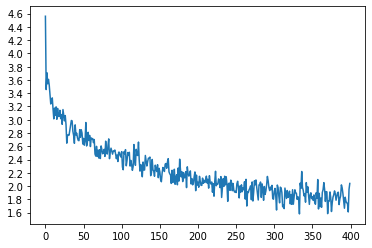

In [35]:
hidden_size = 256
encoder_mlp = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder_mlp = MLPAttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder_mlp, attn_decoder_mlp, 40000, print_every=5000)

In [25]:
evaluateRandomly(encoder1, attn_decoder1)

> мы пришли тебя поддержать .
= we re here to support you .
< we re here to support you . <EOS>

> мы не убиицы .
= we re not killers .
< we aren t win . <EOS>

> мы очень довольны результатом .
= we re very pleased with the result .
< we re very pleased with the result . <EOS>

> я снимаю кино .
= i m making a movie .
< i m making a movie . <EOS>

> я твои сосед .
= i m your neighbor .
< i m your neighbor . <EOS>

> я попробую .
= i m going to try .
< i m a . . <EOS>

> я не особо переживаю .
= i m not particularly worried .
< i m not even worried . <EOS>

> ты очень фотогенична .
= you re very photogenic .
< you re very conservative . <EOS>

> я очень боюсь собак .
= i m very afraid of dogs .
< i m very afraid of dogs . <EOS>

> я женюсь в понедельник .
= i m getting married on monday .
< i m getting married on monday . <EOS>



In [26]:
evaluateRandomly(encoder_scalar, attn_decoder_scalar)

> ты гораздо выше тома .
= you re much taller than tom .
< you re way taller than tom . <EOS>

> я собираюсь спать здесь .
= i m going to sleep here .
< i m going to sleep here . <EOS>

> я сегодня дома .
= i m at home today .
< i m at home today . <EOS>

> я пытаюсь это изменить .
= i m trying to change that .
< i m trying to change that . <EOS>

> теперь я женат .
= i m married now .
< i m married married now . <EOS>

> я всего лишь турист .
= i m just a tourist .
< i m only a tourist . <EOS>

> я очень недовольна .
= i m very angry .
< i m very angry . <EOS>

> я впечатлена твоеи работои .
= i m impressed with your work .
< i m impressed at your work . <EOS>

> я здесь бесполезен .
= i m unnecessary here .
< i m here here . <EOS>

> я уже не голодна .
= i m not hungry anymore .
< i m not longer hungry anymore . <EOS>



In [36]:
evaluateRandomly(encoder_mlp, attn_decoder_mlp)

> я не очень счастлив .
= i m not really happy .
< i m not very happy all very happy . <EOS>

> я довольно высокии .
= i m quite tall .
< i m pretty tall . <EOS>

> я очень богат .
= i m very wealthy .
< i m very very . <EOS>

> я просто немного устала .
= i m just a little tired .
< i m just tired of tired . <EOS>

> я собираюсь остаться с вами .
= i m going to stay with you .
< i m going to go to . . <EOS>

> я тоже не так занят .
= i m not so busy either .
< i m not so not busy . <EOS>

> я так рад что вы здесь .
= i m so happy you re here .
< i m so glad you re here here . <EOS>

> ему под шестьдесят .
= he s in his late fifties .
< he s been on his his . <EOS>

> я здесь для того чтобы слушать .
= i m here to listen .
< i m here to ask . <EOS>

> я твои .
= i m yours .
< i m your . <EOS>



In [0]:
%matplotlib inline

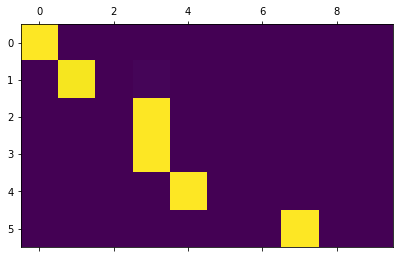

In [29]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "она моя подруга .")
plt.matshow(attentions.numpy())
plt.show()

In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


input = я пытаюсь это изменить .
output = i m trying to fix it . <EOS>


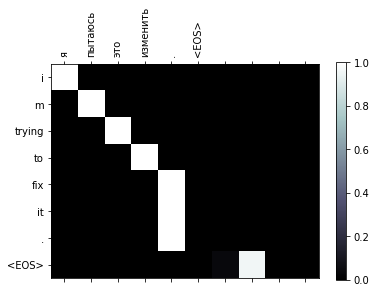

input = я пытаюсь это изменить .
output = i m trying to change that . <EOS>


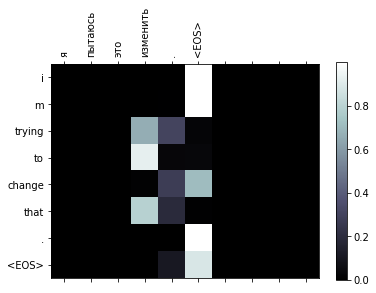

input = я пытаюсь это изменить .
output = i m trying to that . <EOS>


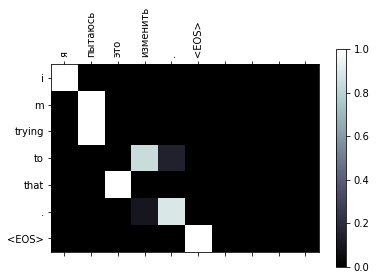

In [37]:
input_sentence = 'я пытаюсь это изменить .'

evaluateAndShowAttention(input_sentence, encoder1, attn_decoder1)
evaluateAndShowAttention(input_sentence, encoder_scalar, attn_decoder_scalar)
evaluateAndShowAttention(input_sentence, encoder_mlp, attn_decoder_mlp)